In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression as LR
 
#其实日常在导库的时候，并不是一次性能够知道我们要用的所有库的。通常都是在建模过程中逐渐导入需要的库。

In [6]:
data = pd.read_csv(r"D:\OneDrive\OneDrive - The University of Tokyo\课程\机器学习\【机器学习】菜菜的sklearn课堂(1-12全课)\05逻辑回归与评分卡\rankingcard.csv",index_col=0)

In [7]:
#观察数据类型
data.head()#注意可以看到第一列为标签，剩下的10列为特征
 
#观察数据结构
data.shape#(150000, 11)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [8]:
#去除重复值
data.drop_duplicates(inplace=True)#inplace=True表示替换原数据
#删除之后千万不要忘记，恢复索引
data.index = range(data.shape[0])

In [9]:
#探索缺失值
data.info()
data.isnull().sum()/data.shape[0]#得到缺失值的比例
#data.isnull().mean()#上一行代码的另一种形式书写

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149391 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149391 non-null  float64
 2   age                                   149391 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149391 non-null  int64  
 4   DebtRatio                             149391 non-null  float64
 5   MonthlyIncome                         120170 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149391 non-null  int64  
 7   NumberOfTimes90DaysLate               149391 non-null  int64  
 8   NumberRealEstateLoansOrLines          149391 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149391 non-null  int64  
 10  NumberOfDependents                    145563 non-null  float64
dtype

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.195601
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.025624
dtype: float64

In [10]:
data["NumberOfDependents"].fillna(int(data["NumberOfDependents"].mean()),inplace=True)
#这里用均值填补家庭人数这一项 
#如果你选择的是删除那些缺失了2.5%的特征，千万记得恢复索引哟~
 
data.info()
data.isnull().sum()/data.shape[0]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149391 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149391 non-null  float64
 2   age                                   149391 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149391 non-null  int64  
 4   DebtRatio                             149391 non-null  float64
 5   MonthlyIncome                         120170 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149391 non-null  int64  
 7   NumberOfTimes90DaysLate               149391 non-null  int64  
 8   NumberRealEstateLoansOrLines          149391 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149391 non-null  int64  
 10  NumberOfDependents                    149391 non-null  float64
dtype

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.195601
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.000000
dtype: float64

In [11]:
def fill_missing_rf(X,y,to_fill):
    #构建我们的新特征矩阵和新标签
    df = X.copy()
    fill = df.loc[:,to_fill]
    df = pd.concat([df.loc[:,df.columns != to_fill],pd.DataFrame(y)],axis=1)
    # 找出我们的训练集和测试集
    Ytrain = fill[fill.notnull()]
    Ytest = fill[fill.isnull()]
    Xtrain = df.iloc[Ytrain.index,:]
    Xtest = df.iloc[Ytest.index,:]
    #用随机森林回归来填补缺失值
    from sklearn.ensemble import RandomForestRegressor as rfr
    rfr = rfr(n_estimators=100)
    rfr = rfr.fit(Xtrain, Ytrain)
    Ypredict = rfr.predict(Xtest)
    return Ypredict

In [12]:
X = data.iloc[:,1:]
y = data["SeriousDlqin2yrs"]#y = data.iloc[:,0]
X.shape#(149391, 10)
y_pred = fill_missing_rf(X,y,"MonthlyIncome")
data.loc[data["MonthlyIncome"].isnull(),"MonthlyIncome"] = y_pred
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149391 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149391 non-null  float64
 2   age                                   149391 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149391 non-null  int64  
 4   DebtRatio                             149391 non-null  float64
 5   MonthlyIncome                         149391 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149391 non-null  int64  
 7   NumberOfTimes90DaysLate               149391 non-null  int64  
 8   NumberRealEstateLoansOrLines          149391 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149391 non-null  int64  
 10  NumberOfDependents                    149391 non-null  float64
dtype

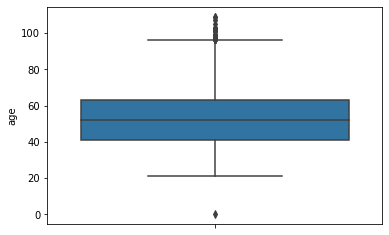

In [13]:
import seaborn as sns
sns.boxplot(y='age',data=data,fliersize=5)
# 显然age存在异常

In [11]:
#描述性统计
#处理异常值通常用箱线图
data.describe([0.01,0.1,0.25,.5,.75,.9,.99]).T 
#分位值，0.01=百分之1的数据小于该数值，.99表示百分之99的数据小于该数值

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
SeriousDlqin2yrs,149391.0,0.066999,0.250021,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
RevolvingUtilizationOfUnsecuredLines,149391.0,6.071087,250.263672,0.0,0.0,0.003199,0.030132,0.154235,0.556494,0.978007,1.093922,50708.0
age,149391.0,52.306237,14.725962,0.0,24.0,33.000000,41.000000,52.000000,63.000000,72.000000,87.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,149391.0,0.393886,3.852953,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,98.0
DebtRatio,149391.0,354.436740,2041.843455,0.0,0.0,0.034991,0.177441,0.368234,0.875279,1275.000000,4985.100000,329664.0
MonthlyIncome,149391.0,5423.118786,13228.172944,0.0,0.0,0.180000,1800.000000,4417.000000,7416.000000,10800.000000,23200.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,149391.0,8.480892,5.136515,0.0,0.0,3.000000,5.000000,8.000000,11.000000,15.000000,24.000000,58.0
NumberOfTimes90DaysLate,149391.0,0.238120,3.826165,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,98.0
NumberRealEstateLoansOrLines,149391.0,1.022391,1.130196,0.0,0.0,0.000000,0.000000,1.000000,2.000000,2.000000,4.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,149391.0,0.212503,3.810523,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,98.0


In [14]:
#异常值也被我们观察到，年龄的最小值居然有0，这不符合银行的业务需求，即便是儿童账户也要至少8岁，我们可以
# 查看一下年龄为0的人有多少
(data["age"] == 0).sum()
#发现只有一个人年龄为0，可以判断这肯定是录入失误造成的，可以当成是缺失值来处理，直接删除掉这个样本
data = data[data["age"] != 0]
"""
另外，有三个指标看起来很奇怪：
 
"NumberOfTime30-59DaysPastDueNotWorse"
"NumberOfTime60-89DaysPastDueNotWorse"
"NumberOfTimes90DaysLate"
 
这三个指标分别是“过去两年内出现35-59天逾期但是没有发展的更坏的次数”，“过去两年内出现60-89天逾期但是没
有发展的更坏的次数”,“过去两年内出现90天逾期的次数”。这三个指标，在99%的分布的时候依然是2，最大值却是
98，看起来非常奇怪。一个人在过去两年内逾期35~59天98次，一年6个60天，两年内逾期98次这是怎么算出来的？
 
我们可以去咨询业务人员，请教他们这个逾期次数是如何计算的。如果这个指标是正常的，那这些两年内逾期了98次的
客户，应该都是坏客户。在我们无法询问他们情况下，我们查看一下有多少个样本存在这种异常：
 
"""
data[data.loc[:,"NumberOfTimes90DaysLate"] > 90]
data[data.loc[:,"NumberOfTimes90DaysLate"] > 90].count()
data.loc[:,"NumberOfTimes90DaysLate"].value_counts()
 
#有225个样本存在这样的情况，并且这些样本，我们观察一下，标签并不都是1，他们并不都是坏客户。因此，我们基
# 本可以判断，这些样本是某种异常，应该把它们删除。
 
data = data[data.loc[:,"NumberOfTimes90DaysLate"] < 90]
#一定要恢复索引
data.index = range(data.shape[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149165 entries, 0 to 149164
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149165 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149165 non-null  float64
 2   age                                   149165 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149165 non-null  int64  
 4   DebtRatio                             149165 non-null  float64
 5   MonthlyIncome                         149165 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149165 non-null  int64  
 7   NumberOfTimes90DaysLate               149165 non-null  int64  
 8   NumberRealEstateLoansOrLines          149165 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149165 non-null  int64  
 10  NumberOfDependents                    149165 non-null  float64
dtype

## 为什么不统一量纲，标准化数据：由于业务需要，如果标准化后，如年龄，都变成小数，虽然对于预测不错，但其他人员会读不懂这个年龄究竟是多少，所以为了业务需要不能这么做。结合实际情况进行考虑

In [15]:
#探索标签的分布
X = data.iloc[:,1:]
y = data.iloc[:,0]

In [16]:
y.value_counts()
# 样本不均衡

0    139292
1      9873
Name: SeriousDlqin2yrs, dtype: int64

In [17]:
n_sample = X.shape[0]
n_1_sample = y.value_counts()[1]
n_0_sample = y.value_counts()[0] 
print('样本个数：{}; 1占{:.2%}; 0占{:.2%}'.format(n_sample,n_1_sample/n_sample,n_0_sample/n_sample))
#样本个数：149165; 1占6.62%; 0占93.38%

样本个数：149165; 1占6.62%; 0占93.38%


In [18]:
import imblearn
#imblearn是专门用来处理不平衡数据集的库，在处理样本不均衡问题中性能高过sklearn很多
#imblearn里面也是一个个的类，也需要进行实例化，fit拟合，和sklearn用法相似
 
from imblearn.over_sampling import SMOTE
 
sm = SMOTE(random_state=42) #实例化
X,y = sm.fit_resample(X,y) #修正比例

In [21]:
n_sample = X.shape[0]
n_1_sample = y.value_counts()[1]
n_0_sample = y.value_counts()[0] 
print('样本个数：{}; 1占{:.2%}; 0占{:.2%}'.format(n_sample,n_1_sample/n_sample,n_0_sample/n_sample))
# 被调整成了一半一半

样本个数：278584; 1占50.00%; 0占50.00%


接下来就是一些tip

In [117]:
#自动分组函数
model_data["qcut"], updown = pd.qcut(model_data["age"], retbins=True, q=20)#等频分箱
 
"""
pd.qcut，基于分位数的分箱函数，本质是将连续型变量离散化
只能够处理一维数据。返回箱子的上限和下限
参数q：要分箱的个数
参数retbins=True来要求同时返回结构为索引为样本索引，元素为分到的箱子的Series
现在返回两个值：每个样本属于哪个箱子，以及所有箱子的上限和下限
"""
#在这里时让model_data新添加一列叫做“分箱”，这一列其实就是每个样本所对应的箱子
model_data["qcut"].value_counts() #查看分组后情况
#所有箱子的上限和下限
updown

array([ 21.        ,  28.        ,  31.02929781,  34.        ,
        36.66351138,  39.        ,  41.        ,  43.        ,
        45.        ,  46.97968823,  48.49720838,  50.00042325,
        52.        ,  54.        ,  56.        ,  58.6589107 ,
        61.        ,  64.        ,  68.        ,  74.        ,
       107.        ])

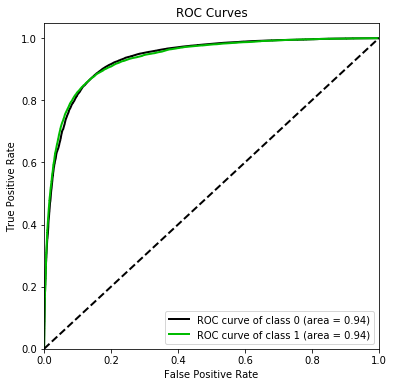

In [136]:
# 画roc曲线
import scikitplot as skplt
 
#%%cmd
#pip install scikit-plot
 
vali_proba_df = pd.DataFrame(lr.predict_proba(vali_X))
skplt.metrics.plot_roc(vali_y, vali_proba_df,
                        plot_micro=False,figsize=(6,6),
                        plot_macro=False)